# Brain Segmentation

This tutorial will show how to use Fed-BioMed to perform image segmentation on 3D medical MRI images of brains, using the publicly available [IXI dataset](https://brain-development.org/ixi-dataset/). 
It uses a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) model for the segmentation, trained on data from 3 separate centers. 

Here we display a very complex case, using advanced Fed-BioMed functionalities such as:
- loading a MedicalImageDataset
- implementing a custom Node Selection Strategy
- setting a non-default Optimizer
- monitoring training loss with Tensorboard

This tutorial is based on [TorchIO's tutorial](https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=OoHXr1a4_9Ll).

## Data preparation

### Donwload  the data
Download the IXI dataset from the [Mendeley archive](https://data.mendeley.com/datasets/7kd5wj7v7p). 
Then separate your data in different folders for each center, in order to achieve the following structure:
```
_ Guys
 |_ train
 | |_ IXI002-Guys-0828
 | |_ ...
 | |_ participants.csv
 |_ holdout
    |_ IXI022-Guys-0701
     |_ ...
     |_ participants.csv
_ HH ....
```

## Automatic download and node creation
The script below will download and split the data into multiple centers (if not existing yet). 

We assume you are running this notebook from the folder `fedbiomed/notebooks/medical-image-segmentation`. If not, please replace the `../../` in the command below with the path to your `fedbiomed` folder.

After succesfully running the command, follow the instructions printed to add the datasets and run the nodes. The tag used for this experiment is `ixi-train`.

In [ ]:
! pip install tqdm

In [ ]:
%run -i download_and_split_ixi.py -f ../..

In [ ]:
%load_ext tensorboard

In [ ]:
! pip install matplotlib

## Create a Training Plan

We create a training plan that incorporates the UNet model. We choose to write the code for the UNet model instead of using the [unet](https://github.com/fepegar/unet) to avoid forcing the edge nodes (i.e. the hospitals) to install an additional dependency. 

Nevertheless, the code for UNet is taken from the library's implementation

*Pérez-García, Fernando. (2020). fepegar/unet: PyTorch implementation of 2D and 3D U-Net (v0.7.5). Zenodo.* https://doi.org/10.5281/zenodo.3697931

### Define the model
We define the model in the `__init__` and `forward` functions of the training plan. Note that this is quite a complex model, requiring multiple subclasses to be defined beforehand.

### Define the loss function
Loss function is computed based on the Dice Loss.

_Carole H Sudre, Wenqi Li, Tom Vercauteren, Sebastien Ourselin, and M Jorge Cardoso. Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations. In Deep learning in medical image analysis and multimodal learning for clinical decision support, pages 240–248. Springer, 2017._

### Define data transformations
We define the image transformations for the input images and the labels. 

Additionally, we define a transformation for the demographics data. Note that this is a required step to ensure that the demographics csv data is transformed into a torch Tensor usable by the training routine.

### Define training step

Here we take as input one batch of (data, target), train the model and compute the loss function. 

Note that the `MedicalFolderDataset` class returns `data` as a tuple of `(images, demographics)`, where:
- `images` is a `dict` of `{modality: image`} (after image transformations)
- `demographics` is a `dict` of `{column_name: values}` where the column names are taken from the demographics csv file
while the `target` is a `dict` of `{modality: image`} (after target transformations). 

In our case, the modality used is `T1` for the input images, while the modality used for the target is `label`. We also ignore the values of the demographics data during training because the UNet model only takes images as input, but the code provided still shows the recommended way to handle such data. 


In [26]:
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager, MedicalFolderDataset
import torch.nn as nn
from torch.optim import AdamW

class UNetTrainingPlan(TorchTrainingPlan):
    
    
    def init_model(self, model_args):
        model = self.Net(model_args)
        return model 
    
    
    def init_optimizer(self):
        optimizer = AdamW(self.model().parameters())
        return optimizer
    
    def init_dependencies(self):
        deps = [
            "from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)",
            "import torch.nn as nn",
            'import torch.nn.functional as F',
            "from fedbiomed.common.data import MedicalFolderDataset",
            'import numpy as np',
            'from torch.optim import AdamW']
        
        return deps

    
    class Net(nn.Module):
        # Init of UNetTrainingPlan
        def __init__(self, model_args: dict = {}):
            super().__init__()
            
            self.CHANNELS_DIMENSION = 1
            in_channels = model_args.get('in_channels',1)
            out_classes = model_args.get('out_classes',2)
            dimensions = model_args.get('dimensions',2)
            num_encoding_blocks = model_args.get('num_encoding_blocks',5)
            out_channels_first_layer = model_args.get('out_channels_first_layer',64)
            normalization = model_args.get('normalization', None)
            pooling_type = model_args.get('pooling_type', 'max')
            upsampling_type = model_args.get('upsampling_type','conv')
            preactivation = model_args.get('preactivation',False)
            residual = model_args.get('residual',False)
            padding = model_args.get('padding',0)
            padding_mode = model_args.get('padding_mode','zeros')
            activation = model_args.get('activation','ReLU')
            initial_dilation = model_args.get('initial_dilation',None)
            dropout = model_args.get('dropout',0)
            monte_carlo_dropout = model_args.get('monte_carlo_dropout',0)

            depth = num_encoding_blocks - 1

            # Force padding if residual blocks
            if residual:
                padding = 1

            # Encoder
            self.encoder = UNetTrainingPlan.Encoder(
                in_channels,
                out_channels_first_layer,
                dimensions,
                pooling_type,
                depth,
                normalization,
                preactivation=preactivation,
                residual=residual,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                initial_dilation=initial_dilation,
                dropout=dropout,
            )

            # Bottom (last encoding block)
            in_channels = self.encoder.out_channels
            if dimensions == 2:
                out_channels_first = 2 * in_channels
            else:
                out_channels_first = in_channels

            self.bottom_block = UNetTrainingPlan.EncodingBlock(
                in_channels,
                out_channels_first,
                dimensions,
                normalization,
                pooling_type=None,
                preactivation=preactivation,
                residual=residual,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=self.encoder.dilation,
                dropout=dropout,
            )

            # Decoder
            if dimensions == 2:
                power = depth - 1
            elif dimensions == 3:
                power = depth
            in_channels = self.bottom_block.out_channels
            in_channels_skip_connection = out_channels_first_layer * 2**power
            num_decoding_blocks = depth
            self.decoder = UNetTrainingPlan.Decoder(
                in_channels_skip_connection,
                dimensions,
                upsampling_type,
                num_decoding_blocks,
                normalization=normalization,
                preactivation=preactivation,
                residual=residual,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                initial_dilation=self.encoder.dilation,
                dropout=dropout,
            )

            # Monte Carlo dropout
            self.monte_carlo_layer = None
            if monte_carlo_dropout:
                dropout_class = getattr(nn, 'Dropout{}d'.format(dimensions))
                self.monte_carlo_layer = dropout_class(p=monte_carlo_dropout)

            # Classifier
            if dimensions == 2:
                in_channels = out_channels_first_layer
            elif dimensions == 3:
                in_channels = 2 * out_channels_first_layer
            self.classifier = UNetTrainingPlan.ConvolutionalBlock(
                dimensions, in_channels, out_classes,
                kernel_size=1, activation=None,
            )
            
        def forward(self, x):
            skip_connections, encoding = self.encoder(x)
            encoding = self.bottom_block(encoding)
            x = self.decoder(skip_connections, encoding)
            if self.monte_carlo_layer is not None:
                x = self.monte_carlo_layer(x)
            x = self.classifier(x)
            x = F.softmax(x, dim=self.CHANNELS_DIMENSION)
            return x
            
    #### Conv ####
    class ConvolutionalBlock(nn.Module):
        def __init__(
                self,
                dimensions: int,
                in_channels: int,
                out_channels: int,
                normalization = None,
                kernel_size: int = 3,
                activation = 'ReLU',
                preactivation: bool = False,
                padding: int = 0,
                padding_mode: str = 'zeros',
                dilation = None,
                dropout: float = 0,
                ):
            super().__init__()

            block = nn.ModuleList()

            dilation = 1 if dilation is None else dilation
            if padding:
                total_padding = kernel_size + 2 * (dilation - 1) - 1
                padding = total_padding // 2

            class_name = 'Conv{}d'.format(dimensions)
            conv_class = getattr(nn, class_name)
            no_bias = not preactivation and (normalization is not None)
            conv_layer = conv_class(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding,
                padding_mode=padding_mode,
                dilation=dilation,
                bias=not no_bias,
            )

            norm_layer = None
            if normalization is not None:
                class_name = '{}Norm{}d'.format(
                    normalization.capitalize(), dimensions)
                norm_class = getattr(nn, class_name)
                num_features = in_channels if preactivation else out_channels
                norm_layer = norm_class(num_features)

            activation_layer = None
            if activation is not None:
                activation_layer = getattr(nn, activation)()

            if preactivation:
                self.add_if_not_none(block, norm_layer)
                self.add_if_not_none(block, activation_layer)
                self.add_if_not_none(block, conv_layer)
            else:
                self.add_if_not_none(block, conv_layer)
                self.add_if_not_none(block, norm_layer)
                self.add_if_not_none(block, activation_layer)

            dropout_layer = None
            if dropout:
                class_name = 'Dropout{}d'.format(dimensions)
                dropout_class = getattr(nn, class_name)
                dropout_layer = dropout_class(p=dropout)
                self.add_if_not_none(block, dropout_layer)

            self.conv_layer = conv_layer
            self.norm_layer = norm_layer
            self.activation_layer = activation_layer
            self.dropout_layer = dropout_layer

            self.block = nn.Sequential(*block)

        def forward(self, x):
            return self.block(x)

        @staticmethod
        def add_if_not_none(module_list, module):
            if module is not None:
                module_list.append(module)

    #### Decoding ####

    CHANNELS_DIMENSION = 1
    UPSAMPLING_MODES = (
        'nearest',
        'linear',
        'bilinear',
        'bicubic',
        'trilinear',
    )


    class Decoder(nn.Module):
        def __init__(
                self,
                in_channels_skip_connection: int,
                dimensions: int,
                upsampling_type: str,
                num_decoding_blocks: int,
                normalization,
                preactivation: bool = False,
                residual: bool = False,
                padding: int = 0,
                padding_mode: str = 'zeros',
                activation = 'ReLU',
                initial_dilation = None,
                dropout: float = 0,
                ):
            super().__init__()
            upsampling_type = UNetTrainingPlan.fix_upsampling_type(upsampling_type, dimensions)
            self.decoding_blocks = nn.ModuleList()
            self.dilation = initial_dilation
            for _ in range(num_decoding_blocks):
                decoding_block = UNetTrainingPlan.DecodingBlock(
                    in_channels_skip_connection,
                    dimensions,
                    upsampling_type,
                    normalization=normalization,
                    preactivation=preactivation,
                    residual=residual,
                    padding=padding,
                    padding_mode=padding_mode,
                    activation=activation,
                    dilation=self.dilation,
                    dropout=dropout,
                )
                self.decoding_blocks.append(decoding_block)
                in_channels_skip_connection //= 2
                if self.dilation is not None:
                    self.dilation //= 2

        def forward(self, skip_connections, x):
            zipped = zip(reversed(skip_connections), self.decoding_blocks)
            for skip_connection, decoding_block in zipped:
                x = decoding_block(skip_connection, x)
            return x


    class DecodingBlock(nn.Module):
        def __init__(
                self,
                in_channels_skip_connection: int,
                dimensions: int,
                upsampling_type: str,
                normalization,
                preactivation: bool = True,
                residual: bool = False,
                padding: int = 0,
                padding_mode: str = 'zeros',
                activation = 'ReLU',
                dilation = None,
                dropout: float = 0,
                ):
            super().__init__()

            self.residual = residual

            if upsampling_type == 'conv':
                in_channels = out_channels = 2 * in_channels_skip_connection
                self.upsample = UNetTrainingPlan.get_conv_transpose_layer(
                    dimensions, in_channels, out_channels)
            else:
                self.upsample = UNetTrainingPlan.get_upsampling_layer(upsampling_type)
            in_channels_first = in_channels_skip_connection * (1 + 2)
            out_channels = in_channels_skip_connection
            self.conv1 = UNetTrainingPlan.ConvolutionalBlock(
                dimensions,
                in_channels_first,
                out_channels,
                normalization=normalization,
                preactivation=preactivation,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=dilation,
                dropout=dropout,
            )
            in_channels_second = out_channels
            self.conv2 = UNetTrainingPlan.ConvolutionalBlock(
                dimensions,
                in_channels_second,
                out_channels,
                normalization=normalization,
                preactivation=preactivation,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=dilation,
                dropout=dropout,
            )

            if residual:
                self.conv_residual = UNetTrainingPlan.ConvolutionalBlock(
                    dimensions,
                    in_channels_first,
                    out_channels,
                    kernel_size=1,
                    normalization=None,
                    activation=None,
                )

        def forward(self, skip_connection, x):
            x = self.upsample(x)
            skip_connection = self.center_crop(skip_connection, x)
            x = torch.cat((skip_connection, x), 
                          dim=UNetTrainingPlan.CHANNELS_DIMENSION)
            if self.residual:
                connection = self.conv_residual(x)
                x = self.conv1(x)
                x = self.conv2(x)
                x += connection
            else:
                x = self.conv1(x)
                x = self.conv2(x)
            return x

        def center_crop(self, skip_connection, x):
            skip_shape = torch.tensor(skip_connection.shape)
            x_shape = torch.tensor(x.shape)
            crop = skip_shape[2:] - x_shape[2:]
            half_crop = crop // 2
            # If skip_connection is 10, 20, 30 and x is (6, 14, 12)
            # Then pad will be (-2, -2, -3, -3, -9, -9)
            pad = -torch.stack((half_crop, half_crop)).t().flatten()
            skip_connection = F.pad(skip_connection, pad.tolist())
            return skip_connection
    
    #### Encoding ####
    class Encoder(nn.Module):
        def __init__(
                self,
                in_channels: int,
                out_channels_first: int,
                dimensions: int,
                pooling_type: str,
                num_encoding_blocks: int,
                normalization,
                preactivation: bool = False,
                residual: bool = False,
                padding: int = 0,
                padding_mode: str = 'zeros',
                activation = 'ReLU',
                initial_dilation = None,
                dropout: float = 0,
                ):
            super().__init__()

            self.encoding_blocks = nn.ModuleList()
            self.dilation = initial_dilation
            is_first_block = True
            for _ in range(num_encoding_blocks):
                encoding_block = UNetTrainingPlan.EncodingBlock(
                    in_channels,
                    out_channels_first,
                    dimensions,
                    normalization,
                    pooling_type,
                    preactivation,
                    is_first_block=is_first_block,
                    residual=residual,
                    padding=padding,
                    padding_mode=padding_mode,
                    activation=activation,
                    dilation=self.dilation,
                    dropout=dropout,
                )
                is_first_block = False
                self.encoding_blocks.append(encoding_block)
                if dimensions == 2:
                    in_channels = out_channels_first
                    out_channels_first = in_channels * 2
                elif dimensions == 3:
                    in_channels = 2 * out_channels_first
                    out_channels_first = in_channels
                if self.dilation is not None:
                    self.dilation *= 2

        def forward(self, x):
            skip_connections = []
            for encoding_block in self.encoding_blocks:
                x, skip_connnection = encoding_block(x)
                skip_connections.append(skip_connnection)
            return skip_connections, x

        @property
        def out_channels(self):
            return self.encoding_blocks[-1].out_channels
    
    class EncodingBlock(nn.Module):
        def __init__(
                self,
                in_channels: int,
                out_channels_first: int,
                dimensions: int,
                normalization,
                pooling_type,
                preactivation: bool = False,
                is_first_block: bool = False,
                residual: bool = False,
                padding: int = 0,
                padding_mode: str = 'zeros',
                activation = 'ReLU',
                dilation= None,
                dropout: float = 0,
                ):
            super().__init__()

            self.preactivation = preactivation
            self.normalization = normalization

            self.residual = residual

            if is_first_block:
                normalization = None
                preactivation = None
            else:
                normalization = self.normalization
                preactivation = self.preactivation

            self.conv1 = UNetTrainingPlan.ConvolutionalBlock(
                dimensions,
                in_channels,
                out_channels_first,
                normalization=normalization,
                preactivation=preactivation,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=dilation,
                dropout=dropout,
            )

            if dimensions == 2:
                out_channels_second = out_channels_first
            elif dimensions == 3:
                out_channels_second = 2 * out_channels_first
            self.conv2 = UNetTrainingPlan.ConvolutionalBlock(
                dimensions,
                out_channels_first,
                out_channels_second,
                normalization=self.normalization,
                preactivation=self.preactivation,
                padding=padding,
                activation=activation,
                dilation=dilation,
                dropout=dropout,
            )

            if residual:
                self.conv_residual = UNetTrainingPlan.ConvolutionalBlock(
                    dimensions,
                    in_channels,
                    out_channels_second,
                    kernel_size=1,
                    normalization=None,
                    activation=None,
                )

            self.downsample = None
            if pooling_type is not None:
                self.downsample = UNetTrainingPlan.get_downsampling_layer(dimensions, pooling_type)

        def forward(self, x):
            if self.residual:
                connection = self.conv_residual(x)
                x = self.conv1(x)
                x = self.conv2(x)
                x += connection
            else:
                x = self.conv1(x)
                x = self.conv2(x)
            if self.downsample is None:
                return x
            else:
                skip_connection = x
                x = self.downsample(x)
                return x, skip_connection

        @property
        def out_channels(self):
            return self.conv2.conv_layer.out_channels
    
    @staticmethod
    def get_upsampling_layer(upsampling_type: str) -> nn.Upsample:
        if upsampling_type not in UNetTrainingPlan.UPSAMPLING_MODES:
            message = (
                'Upsampling type is "{}"'
                ' but should be one of the following: {}'
            )
            message = message.format(upsampling_type, UPSAMPLING_MODES)
            raise ValueError(message)
        upsample = nn.Upsample(
            scale_factor=2,
            mode=upsampling_type,
            align_corners=False,
        )
        return upsample
    
    @staticmethod
    def get_conv_transpose_layer(dimensions, in_channels, out_channels):
        class_name = 'ConvTranspose{}d'.format(dimensions)
        conv_class = getattr(nn, class_name)
        conv_layer = conv_class(in_channels, out_channels, kernel_size=2, stride=2)
        return conv_layer

    @staticmethod
    def fix_upsampling_type(upsampling_type: str, dimensions: int):
        if upsampling_type == 'linear':
            if dimensions == 2:
                upsampling_type = 'bilinear'
            elif dimensions == 3:
                upsampling_type = 'trilinear'
        return upsampling_type
    
    @staticmethod
    def get_downsampling_layer(
            dimensions: int,
            pooling_type: str,
            kernel_size: int = 2,
            ) -> nn.Module:
        class_name = '{}Pool{}d'.format(pooling_type.capitalize(), dimensions)
        class_ = getattr(nn, class_name)
        return class_(kernel_size)

    @staticmethod
    def get_dice_loss(output, target, epsilon=1e-9):
        CHANNELS_DIMENSION = 1
        SPATIAL_DIMENSIONS = 2, 3, 4
        p0 = output
        g0 = target
        p1 = 1 - p0
        g1 = 1 - g0
        tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
        fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
        fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
        num = 2 * tp
        denom = 2 * tp + fp + fn + epsilon
        dice_score = num / denom
        return 1. - dice_score

    @staticmethod
    def demographics_transform(demographics: dict):
        """Transforms dict of demographics into data type for ML.

        This function is provided for demonstration purposes, but
        note that if you intend to use demographics data as part
        of your model's input, you **must** provide a
        `demographics_transform` function which at the very least
        converts the demographics dict into a torch.Tensor.


        Must return either a torch Tensor or something Tensor-like
        that can be easily converted through the torch.as_tensor()
        function."""

        if isinstance(demographics, dict) and len(demographics) == 0:
            # when input is empty dict, we don't want to transform anything
            return demographics

        # simple example: keep only some keys
        keys_to_keep = ['HEIGHT', 'WEIGHT']
        out = np.array([float(val) for key, val in demographics.items() if key in keys_to_keep])

        # more complex: generate dummy variables for site name
        # not ideal as it requires knowing the site names in advance
        # could be better implemented with some preprocess
        site_names = ['Guys', 'IOP', 'HH']
        len_dummy_vars = len(site_names) + 1
        dummy_vars = np.zeros(shape=(len_dummy_vars,))
        site_name = demographics['SITE_NAME']
        if site_name in site_names:
            site_idx = site_names.index(site_name)
        else:
            site_idx = len_dummy_vars - 1
        dummy_vars[site_idx] = 1.

        return np.concatenate((out, dummy_vars))


    def training_data(self):
    # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (48, 60, 48)
        training_transform = Compose([AddChannel(), Resize(common_shape), NormalizeIntensity(),])
        target_transform = Compose([AddChannel(), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        dataset = MedicalFolderDataset(
            root=self.dataset_path,
            data_modalities='T1',
            target_modalities='label',
            transform=training_transform,
            target_transform=target_transform,
            demographics_transform=UNetTrainingPlan.demographics_transform)
        train_kwargs = {'shuffle': True}
        return DataManager(dataset, **train_kwargs)
    
    
    def training_step(self, data, target):
        #this function must return the loss to backward it 
        img = data[0]['T1']
        demographics = data[1]
        output = self.model().forward(img)
        loss = UNetTrainingPlan.get_dice_loss(output, target['label'])
        avg_loss = loss.mean()
        return avg_loss
    
    def testing_step(self, data, target):
        img = data[0]['T1']
        demographics = data[1]
        target = target['label']
        prediction = self.model().forward(img)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        avg_loss = loss.mean()  # average per batch
        return avg_loss


## Prepare the experiment

In [27]:
model_args = {
    'in_channels': 1,
    'out_classes': 2,
    'dimensions': 3,
    'num_encoding_blocks': 3,
    'out_channels_first_layer': 8,
    'normalization': 'batch',
    'upsampling_type': 'linear',
    'padding': True,
    'activation': 'PReLU',
}

training_args = {
    'loader_args': { 'batch_size': 16, },
    'epochs': 2, 
    'dry_run': False,
    'log_interval': 2,
    'test_ratio' : 0.1,
    'test_on_global_updates': True,
    'test_on_local_updates': True,
}

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['ixi-train']
num_rounds = 3

exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=UNetTrainingPlan,
                 training_args=training_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 tensorboard=True
                )

In [29]:
from fedbiomed.researcher.config import config
tensorboard_dir = config.vars['TENSORBOARD_RESULTS_DIR']

In [14]:
%tensorboard --logdir "$tensorboard_dir"

On a Macbook Pro from 2015 with a 2,5 GHz Quad-Core Intel Core i7 processor and 16GB of DRAM, training for 3 rounds of 2 epochs each took about 30 minutes.
The final training curves look like this:

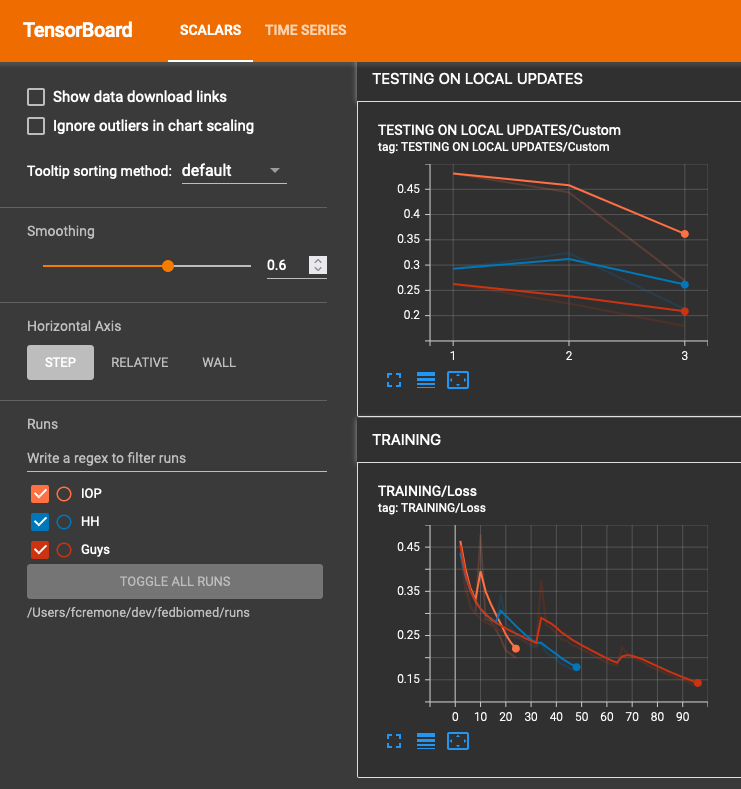

## Run the experiment

In [ ]:
exp.run()

Save trained model to file

In [ ]:
exp.training_plan().export_model('./trained_model')

## Validate on a local holdout set

To ensure consistency and simplify our life, we try to reuse the already-available code as much as possible. Note that this process assumes that the held-out data is stored locally on the machine. 

### Create an instance of the global model
First, we create an instance of the model using the parameters from the latest aggregation round.

In [31]:
from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)
import torch.nn as nn
from fedbiomed.common.data import MedicalFolderDataset
import numpy as np
from torch.optim import AdamW
import torch
from fedbiomed.common.constants import TrainingPlans
import torch.nn.functional as F

In [32]:
local_training_plan = UNetTrainingPlan()
local_model = local_training_plan.init_model(model_args)

In [35]:
for dependency_statement in local_training_plan.init_dependencies():
    exec(dependency_statement)

In [ ]:
local_model.load_state_dict(exp.aggregated_params()[num_rounds-1]['params'])

### Define a validation data loader

We extract the validation data loader from the training plan as well. This requires some knowledge about the internals of the `MedicalFolderDataset` class. At the end of the process, calling the `split` function with a ratio of 0 will return a data loader that loads all of the data.

In [43]:
from torch.utils.data import DataLoader
dataset_parameters = {
    'tabular_file': '../data/Hospital-Centers/Guys/holdout/participants.csv',
    'index_col': 14
}
local_training_plan.dataset_path = '../data/Hospital-Centers/Guys/holdout/'
val_data_manager = local_training_plan.training_data()
val_data_manager._dataset.set_dataset_parameters(dataset_parameters)
val_data_loader = DataLoader(val_data_manager._dataset)

### Compute the loss on validation images

In [44]:
losses = []
local_model.eval()

with torch.no_grad():
    for (images, demographics), targets in val_data_loader:
        image = images['T1']
        target = targets['label']
        prediction = local_model.forward(image)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        losses.append(loss)

### Visualize the outputs

As a bonus, we visualize the outputs of our model on the holdout dataset. 

In [45]:
one_batch = next(iter(val_data_loader))

`one_batch` contains both input features and labels. Both are 3D images, which can be accessed in the following way (`k` represents the _height_ in the stack of images):

In [46]:
k = 24
one_batch[1]['label'][..., k].shape

torch.Size([1, 2, 48, 60])

In [47]:
k = 24
one_batch[0][0]['T1'][..., k].shape

torch.Size([1, 1, 48, 60])

In [48]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
import torchvision
from IPython import display

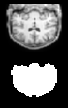

In [49]:
k = 24
batch_mri = one_batch[0][0]['T1'][..., k]
batch_label = one_batch[1]['label'][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=max(val_data_loader.batch_size//2,1),
    normalize=True,
    scale_each=True,
    padding=4,
)
display.Image(image_path, width=300)